In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import numba 

import pickle
from pcygni_5 import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top   = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6 , zorder = 1, top   = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6 , zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)
    warnings.warn("IntegrationWarning", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
import warnings
warnings.filterwarnings("ignore")

In [3]:
OB = 'OB2'

In [4]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

x = np.loadtxt(path+'/'+files[1]).T
#x= np.array([wl, flux, error,error]).T
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
          (x[:,0] > 4000) & (x[:,0] < 22500)

wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]

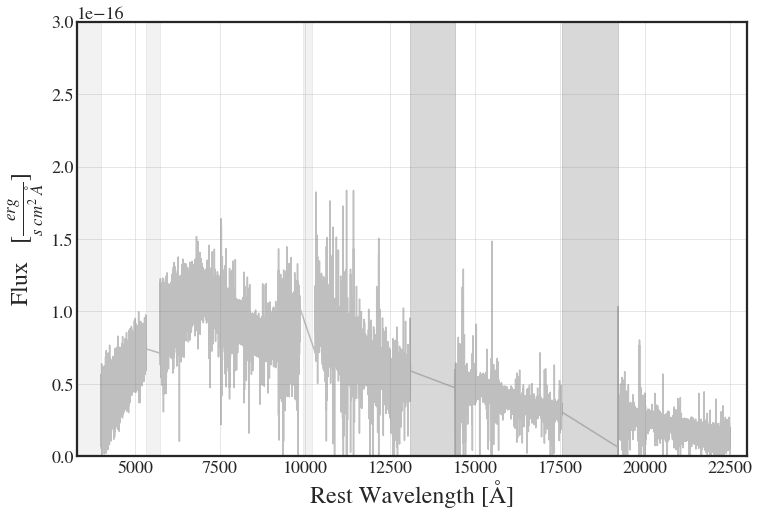

In [5]:
reset_plt(18,24)
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(wl, flux, label='X-shooter spectra', color='grey', alpha=0.5)

#plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
#plt.fill_between(x[:,0], x[:,1]-x[:,2], x[:,1]+x[:,2], 
#                 color='grey', alpha=0.9)
plt.ylim(0, 3e-16), plt.xlim(3300, 23000)

#define telluric region
ax.fill_between([13100, 14400], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')
#plt.xlim(9000,12000)
#plt.xscale('log') 
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)

In [43]:
from astropy.modeling import models

#area
x_arr = np.linspace(0, np.pi/2, 10)
x_center = (x_arr[1:]+x_arr[:-1])/2
areas = 3*np.sin(x_center)*np.cos(x_center)**2 * (x_arr[1]-x_arr[0])

def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, vref=0.2, ve=0.2, t0 = 120960): 
    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA)#, _lam_min=7000, _lam_max=13000)
    
    cyg = prof_calc.calc_profile_Flam( npoints=25 )  
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)    
    return inter(wl)

@numba.njit(fastmath=True)
def temp(wav,T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )

@numba.njit(fastmath=True)
def temp2(wav,T,corr):
    wav = wav*corr
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )
    
@numba.njit(fastmath=True)
def gaussian(wav, amp, mu, sigma): 
    return amp*np.exp(-(wav-mu)**2/(2*sigma**2))
    
def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32,
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vbb = 0.2, T_power = 0.54,
                    vref=0., t0=120960, lam=10506.3653): #blackbody
    
    #vbb=0.28
    ##this part correctly weighs the areas
    corr = (1-vbb**2)**(1/2)*1/(1-vbb*np.cos(x_center))
    
    #This includes the cooling of temperatures using Drout2017
    t = vbb*t0/(1-vbb) - np.cos(x_center) * (vbb*t0)/(1-vbb*np.cos(x_center))
    #print('corr=',corr)
    #time = t0-t
    #T_n = 2642 + T * time**(-T_power)#
    T_n = T*((t0-t)/t0)**(-T_power)
    #print('Tn=',T_n)
    
    #intensity = np.average([temp2(wav, T_i, i)*i**5 for i,T_i in zip(corr,T_n)], axis=0, weights=areas)
    intensity = np.average([temp(wav, T_i*i) for i,T_i in zip(corr,T_n)], axis=0, weights=areas)
    
    #intensity = temp(wav, 2*T)

    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)

    intensity = intensity*correction
    return N*intensity+gau1+gau2


def residual(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]
    vbb = v['v_bb']
    T_power = v['T_power']
    
    
    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2, t0=t0, 
                            vbb=vbb, T_power = T_power)
    
    if data is None:
        return model
    return (model - data)/error

import lmfit
beta, doppler = np.loadtxt('doppler_wo_prolate_inv.txt')
inter = interp1d(beta, doppler)
print(inter(0.27))
def lum_dist_arr(N, vphot, n_days=1.43, dt=0., correct=True): #propagate bb to luminosity distance 
    delta = inter(vphot) #1-2/3*11/10*vphot
    corr = delta**4
    
    if correct: 
        theta = 2*np.sqrt(N*10**(7) / corr )
        
    else: 
        theta = 2*np.sqrt(N*10**(7) ) 

    v = vphot*c #factor of 2
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23)
    return D_mpc


n_days = [1.427, 2.417, 3.413, 4.403]

1.2123076047722938


In [7]:
inter(0.2835)#**4

array(1.22358171)

In [10]:
@numba.njit(fastmath=True)
def lnprob_inner(model, flux, error):
    return -0.5 * np.sum(((model - flux) / error)**2 + np.log(2 * np.pi * error**2))

def lnprob(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl*1e-10)
    return lnprob_inner(model, flux, error)

#### Fit structure

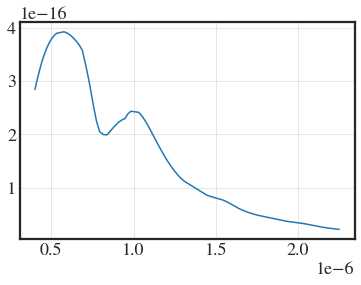

In [16]:
plt.plot(wl*1e-10, residual(p, wl*1e-10))

In [22]:
p

name,value,initial value,min,max,vary
T,3950.00000,3950,2500.00000,7500.00000,True
N,2.7000e-29,2.7e-29,-inf,inf,True
vphot,0.24000000,0.24,0.00000000,1.00000000,True
vmax,0.33120000,0.3312,0.00000000,1.00000000,True
t0,212400.000,212400,-inf,inf,False
tau,10.0000000,10.0,0.00000000,20.0000000,True
vref,0.00000000,0.0,0.00000000,1.00000000,False
ve,0.11000000,0.11,0.00000000,0.20000000,True
v_bb,0.24000000,0.24,0.00000000,1.00000000,True
T_power,0.40000000,0.4,0.00000000,3.00000000,True


In [41]:
p = lmfit.Parameters()
OB = 'OB2'
with open("./data/%s_conv_init.json"%OB, 'r') as infile:
    p.load(infile)
#convolve wrong
#p['T'].value=6700p['N'].value=5e-30

#p['T'].value=5400/1.3;  
#p['v_bb'].value=0.26  ; p['v_bb'].vary=True  
p['T_power'].value=0.36; p['T_power'].vary=False; 
#p['vphot'].value=0.28; 

start = time.time()
mi2 = lmfit.minimize(residual, p, method='Nelder', args=(wl*1e-10, flux, error))
end = time.time()
print('Time elapsed:',(end-start)/60) 

Time elapsed: 1.5125209490458171


In [42]:
print(lum_dist_arr(mi2.params['N'],mi2.params['vphot'],n_days=2.42, correct = True) )
mi2.params['T'], mi2.params['vphot'], mi2.params['v_bb'], mi2.params['T_power'], mi2.params['N'], mi2.params['vmax']

40.405983402057245


(<Parameter 'T', value=3220.4250094061726, bounds=[2500:7500]>,
 <Parameter 'vphot', value=0.23905010401196408, bounds=[0:1]>,
 <Parameter 'v_bb', value=0.22274971019708006, bounds=[0:1]>,
 <Parameter 'T_power', value=0.36 (fixed), bounds=[0:3]>,
 <Parameter 'N', value=2.8689227055106864e-29, bounds=[-inf:inf]>,
 <Parameter 'vmax', value=0.27569611360814933, bounds=[0:1]>)

In [28]:
with open("./data/%s_convolved_0.json"%OB, 'w') as outfile:
    mi2.params.dump(outfile)    

In [29]:
p = lmfit.Parameters()
with open("./Data/%s_convolved_0.json"%OB, 'r') as infile:
    p.load(infile)
#pickle_in = open("./data/OB1/OB1_3_peaks_convolved_5000.pkl","rb")
#emcee_res = pickle.load(pickle_in)
#p = emcee_res.params
#p
print(lum_dist_arr(p['N'],p['vphot'],n_days=1.45), p['ve'], p['vphot'])
#p['amp1'].vary=False
#p['amp2'].vary=False
#p['sig1'].vary=False
#p['sig2'].vary=False
#p['occult'].vary=False

p

25.170059021366058 <Parameter 've', value=0.11175494188271487, bounds=[0:0.2]> <Parameter 'vphot', value=0.24351956695159227, bounds=[0:1]>


name,value,initial value,min,max,vary
T,3254.06574,3950,2500.00000,7500.00000,True
N,2.7887e-29,2.7e-29,-inf,inf,True
vphot,0.24351957,0.24,0.00000000,1.00000000,True
vmax,0.27893198,0.3312,0.00000000,1.00000000,True
t0,212400.000,212400,-inf,inf,False
tau,10.0015386,10.0,0.00000000,20.0000000,True
vref,0.00000000,0.0,0.00000000,1.00000000,False
ve,0.11175494,0.11,0.00000000,0.20000000,True
v_bb,0.20823242,0.24,0.00000000,1.00000000,True
T_power,0.46000000,0.46,0.00000000,3.00000000,False


In [34]:
p['vphot']

<Parameter 'vphot', value=0.25 +/- 0.00255, bounds=[0:1]>

In [35]:
pickle_in = open("./data/OB2/OB2_3_peaks_convolved_free_vbb_0.pkl","rb")
res2 = pickle.load(pickle_in)
p = res2.params
p['T_power'].max=3
p['T_power'].value=2; p['T_power'].vary=False; 
p['v_bb'].value = 0.25

p['T'].value = 3900
p['vphot'].value = 0.25
p

name,value,standard error,relative error,initial value,min,max,vary
T,3900.00000,244.023603,(6.26%),3254.0657359467805,2500.00000,7500.00000,True
N,2.9310e-29,9.3768e-32,(0.32%),2.788676881309952e-29,-inf,inf,True
vphot,0.25000000,0.00254572,(1.02%),0.24351956695159227,0.00000000,1.00000000,True
vmax,0.28032127,8.0234e-04,(0.29%),0.27893198475971204,0.00000000,1.00000000,True
t0,212400.000,,(0.29%),212400,-inf,inf,False
tau,8.64299652,2.49047391,(28.81%),10.001538584761501,0.00000000,20.0000000,True
vref,0.00000000,,(28.81%),0.0,0.00000000,1.00000000,False
ve,0.17149603,0.02118545,(12.35%),0.11175494188271487,0.00000000,0.20000000,True
v_bb,0.25000000,0.07617630,(30.47%),0.20823241585991648,0.00000000,1.00000000,True
T_power,2.00000000,,(30.47%),0.46,0.00000000,3.00000000,False


#### Markov Chain Monto Carlo to sample distribution

XL_1 = 10.000 with 50 walkers, wide gaussian

XL_2 = 20.000 with 50 walkers, narrow gaussian

XL_3 = 100.000 with 22 walkers free sigma

XL_4 = 20.000 with 100 walkers, tight constraint on sigma and gaussians set by XL_3.

###### Convolution wrong direction
OB1_3_peaks_convolved.pkl       
OB1_3_peaks_convolved_5000.pkl   
OB1_3_peaks_convolved_20000.pkl - 50 walkers 21.000 steps with 1.000 burnout

###### Convolution - temperature cooling
OB1_3_peaks_convolved_v_bb.pkl  - 20 walkers - 2.000 steps - 0 burnout; 38.3 pm 0.1


OB2_3_peaks_convolved_free_vbb_0 - 20 walkers 10.000 steps - T_power fixed = 0.46, vbb = 0.04 pm 0.04

OB2_3_peaks_convolved_free_vbb_1 - 20 walkers 10.000 steps - T_power fixed = 0.36, vbb = 0.02 pm 0.02


In [36]:
mini = lmfit.Minimizer(lnprob, p) 

start = time.time()
nwalkers = 20 #v = p.valuesdict()
res2 = mini.emcee(nwalkers=nwalkers, burn=0, steps=500, thin=1, params=p, seed=12345, workers = 4)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 )

#with open("./Data/OB1/OB1_3_peaks_XL_4.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

100%|██████████| 500/500 [07:05<00:00,  1.17it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 10 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [42.99824435 47.96864718 35.93941566 58.47438937 44.16411132 58.68694425
 65.74057054 70.3405848  60.32579447 39.75062455]
Time elapsed [hours]: 0.11882829401228162


In [37]:
#with open("./Data/OB2/OB2_3_peaks_convolved_free_vbb_1.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

203.98540864829494 130.5886859583938 288.51153786062355
219.17663273443736 157.41780591272436 294.32580152210323


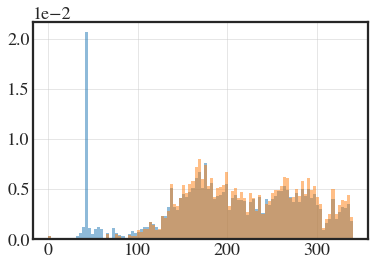

In [38]:
#print(lum_dist_arr(res2.params['N'],res2.params['vphot'],n_days=1.45))
flat = res2.flatchain
dl = lum_dist_arr( flat['N'], flat['vphot'], n_days=2.42, correct = True) #* np.sqrt(np.pi)
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))
plt.hist(dl, bins=100, density=True, alpha=0.5); 

#nwalkers = 22
steady = int(100*nwalkers)
dl = lum_dist_arr( flat['N'][steady:], flat['vphot'][steady:], n_days=2.42, correct = True) #* np.sqrt(np.pi)
plt.hist(dl, bins=100, density=True, alpha=0.5); 
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))

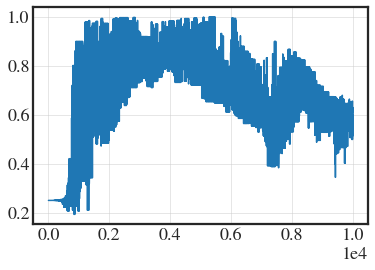

In [42]:
plt.plot(flat['vphot'][:])

In [27]:
p

name,value,standard error,relative error,initial value,min,max,vary
T,3900.00000,244.023603,(6.26%),3254.0657359467805,2500.00000,7500.00000,True
N,2.9310e-29,9.3768e-32,(0.32%),2.788676881309952e-29,-inf,inf,True
vphot,0.25347391,0.00254572,(1.00%),0.24351956695159227,0.00000000,1.00000000,True
vmax,0.28032127,8.0234e-04,(0.29%),0.27893198475971204,0.00000000,1.00000000,True
t0,212400.000,,(0.29%),212400,-inf,inf,False
tau,8.64299652,2.49047391,(28.81%),10.001538584761501,0.00000000,20.0000000,True
vref,0.00000000,,(28.81%),0.0,0.00000000,1.00000000,False
ve,0.17149603,0.02118545,(12.35%),0.11175494188271487,0.00000000,0.20000000,True
v_bb,0.25000000,0.07617630,(30.47%),0.20823241585991648,0.00000000,1.00000000,True
T_power,2.00000000,,(30.47%),0.46,0.00000000,3.00000000,False


In [390]:
plt.plot(flat['T_power'][0::22])
plt.plot(flat['T_power'][1::22])
plt.plot(flat['T_power'][2::22])
plt.plot(flat['T_power'][3::22])
np.mean(flat['T_power'][-1000:]), np.std(flat['T_power'][-1000:])
plt.ylim(0, 1), plt.ylabel(r'$T_{power}$')
#plt.savefig('Pictures/Convolved_bb_free_T_power_fixed_vbb_028.png', dpi=300)

KeyError: 'T_power'

((0.0, 1.0), Text(0, 0.5, '$T_{power}$'))

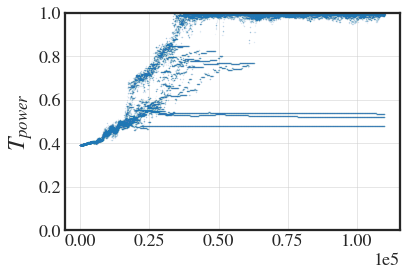

In [257]:
plt.scatter(np.arange(len(flat['T_power'][::])), flat['T_power'][::], alpha=.1, s=.1)
#plt.plot(flat['T_power'][1::22])
#plt.plot(flat['T_power'][2::22])
plt.ylim(0, 1), plt.ylabel(r'$T_{power}$')
#plt.savefig('Pictures/Convolved_bb_free_T_power_free_vbb.png', dpi=300)

Text(0, 0.5, '$v_{bb}$')

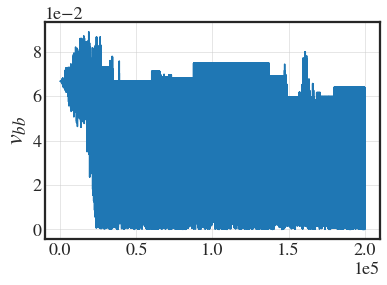

In [51]:
plt.plot(flat['v_bb'][::])
plt.ylabel(r'$v_{bb}$')#, plt.ylim(0,0.45)
#plt.savefig('Pictures/Convolved_bb_free_T_power_free_vbb_2.png', dpi=300)

Text(0, 0.5, '$v_{bb}$')

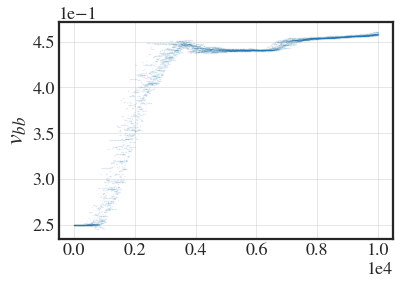

In [28]:
plt.scatter( np.arange(len(flat['v_bb'])) , flat['v_bb'] , s=0.1, alpha=0.1 )
plt.ylabel(r'$v_{bb}$')#, plt.ylim(0,0.45)
#plt.savefig('Pictures/Convolved_bb_free_T_power_free_vbb_2.png', dpi=300)

In [37]:
np.shape(flat['v_bb'][:])

(200000,)

0.020706415329067623 0.017987760932763757
0.25352039850012154 0.0013477990223316745


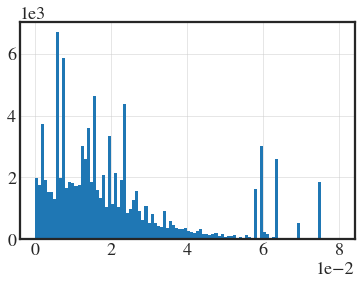

In [53]:
plt.hist(flat['v_bb'][100000:], bins=100)#, range=(0.2, 0.5)); 
#plt.hist(flat['vphot'], bins=100, range=(0.2, 0.5)); 
print(np.mean(flat['v_bb'][100000:]), np.std(flat['v_bb'][100000:]))
print(np.mean(flat['vphot'][100000:]), np.std(flat['vphot'][100000:]))

0.3514619500082524 0.014090128691007137
0.2848179689004851 0.0006751546471874892


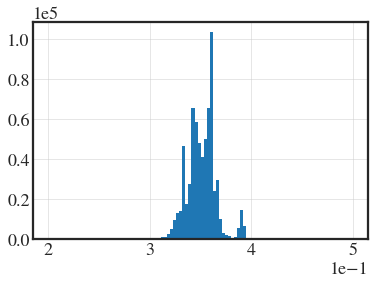

In [324]:
plt.hist(flat['v_bb'][80000:], bins=100, range=(0.2, 0.5)); 
#plt.hist(flat['vphot'], bins=100, range=(0.2, 0.5)); 
print(np.mean(flat['v_bb'][80000:]), np.std(flat['v_bb'][80000:]))
print(np.mean(flat['vphot'][80000:]), np.std(flat['vphot'][80000:]))

In [327]:
import astropy.units as u
import astropy.constants as c
from astropy.cosmology import Planck15 as cosmo
dL = cosmo.luminosity_distance(0.00957).to(u.cm)
dL

<Quantity 1.31646178e+26 cm>

In [350]:
inter(np.median(flat['vphot'][80000:]))

array(1.22475656)

In [358]:
R = flat['N'][80000:]/np.pi*(dL.value)**2 #/(3600*24*1.43*3e10)/1.21**4
vcos = np.sqrt(R*10**7)/(3600*24*1.43*3e10)*inter(flat['vphot'][80000:])
print(np.median(vcos), 3/67*np.median(vcos)) #np.std(vcos))

0.2877758687244444 0.01288548665930348


In [357]:
3/67*np.median(vcos)

0.01288548665930348

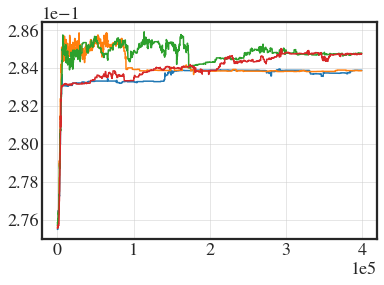

In [152]:
plt.plot(flat['vphot'][::nwalkers])
plt.plot(flat['vphot'][1::nwalkers])
plt.plot(flat['vphot'][2::nwalkers])
plt.plot(flat['vphot'][20::nwalkers])

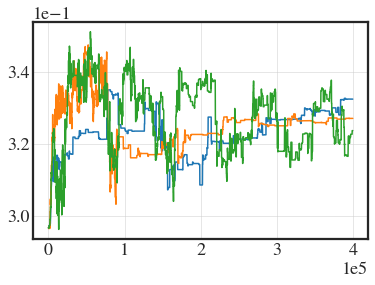

In [156]:
plt.plot(flat['v_bb'][::nwalkers])
plt.plot(flat['v_bb'][1::nwalkers])
plt.plot(flat['v_bb'][2::nwalkers])


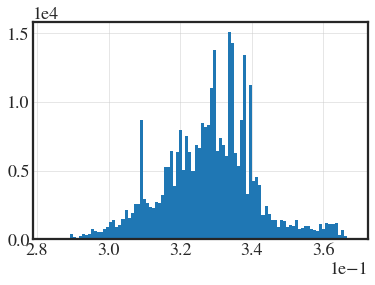

In [162]:
plt.hist(flat['v_bb'][2000*40:], bins=100); 

In [163]:
flat.params

AttributeError: 'DataFrame' object has no attribute 'params'

In [34]:
#with open("./Data/OB1/OB1_3_peaks_convolved_vbb_powerlaw.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

In [35]:
res2.params

name,value,standard error,relative error,initial value,min,max,vary
T,5393.19706,77.5644940,(1.44%),5602.436134861421,2500.00000,7500.00000,True
N,1.3913e-29,8.3079e-31,(5.97%),1.1978423726965341e-29,-inf,inf,True
vphot,0.32199484,0.01415890,(4.40%),0.3484161741055352,0.00000000,1.00000000,True
vmax,0.34392908,0.01898977,(5.52%),0.38195677768673486,0.00000000,1.00000000,True
t0,126000.000,,(5.52%),126000,-inf,inf,False
tau,24.2588452,0.66830411,(2.75%),21.61580899130366,0.00000000,100.000000,True
vref,0.00000000,,(2.75%),0.0,0.00000000,1.00000000,False
ve,0.17426927,0.02317022,(13.30%),0.13024855894188836,0.00000000,1.00000000,True
v_bb,0.00253361,3.3080e-04,(13.06%),0.0019101125772397753,0.00000000,1.00000000,True
T_power,0.11730533,0.14246836,(121.45%),0.39639903465640125,0.00000000,1.00000000,True


In [24]:
#with open("./Data/OB1/OB1_3_peaks_XL_2.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

##### Plot d_l

In [309]:
pickle_in = open("./data/OB1/OB1_3_peaks_convolved_free_vbb_2.pkl","rb")
res2 = pickle.load(pickle_in)
p = res2.params
lum_dist_arr(p['N'],p['vphot'],n_days=1.43), p['ve'], p['vphot']

(43.56449684266719,
 <Parameter 've', value=0.2176118811047037 +/- 0.0241, bounds=[0:1]>,
 <Parameter 'vphot', value=0.2837083374432308 +/- 0.000343, bounds=[0:1]>)

In [267]:
np.shape(flat['v_bb'])

(66000,)

((0.0, 1.0), Text(0, 0.5, '$T_{power}$'))

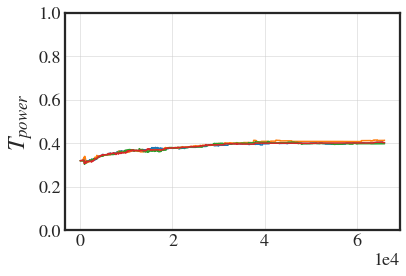

In [263]:
plt.plot(flat['v_bb'][0::22])
plt.plot(flat['v_bb'][1::22])
plt.plot(flat['v_bb'][2::22])
plt.plot(flat['v_bb'][3::22])
np.mean(flat['v_bb'][-1000:]), np.std(flat['v_bb'][-1000:])
plt.ylim(0, 1), plt.ylabel(r'$T_{power}$')
#plt.savefig('Pictures/Convolved_bb_free_T_power_fixed_vbb_028.png', dpi=300)

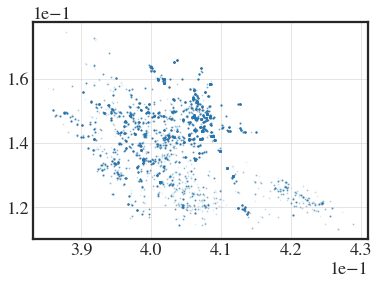

In [271]:
#plt.scatter(flat['v_bb'], flat['T_power'], s=0.1, alpha=0.1)
plt.scatter(flat['v_bb'][-20000:], flat['T_power'][-20000:], s=0.5, alpha=0.1)



In [278]:
4200*1.15,5400*(2.4/1.4)**(-0.25)

(4830.0, 4719.249715525274)

43.069899987905345 42.840470477854936 43.383759122827534
43.087832248243146 42.892039076190365 43.38398196720673


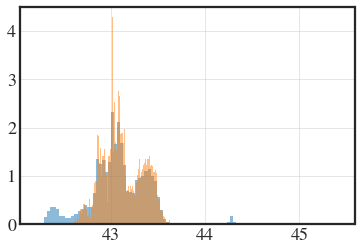

In [261]:
flat = res2.flatchain
dl = lum_dist_arr( flat['N'], flat['vphot'], n_days=1.44) #* np.sqrt(np.pi)
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))
plt.hist(dl, bins=100, density=True, alpha=0.5); 

nwalkers = 20
steady = int(600*nwalkers)
dl = lum_dist_arr( flat['N'][steady:], flat['vphot'][steady:], n_days=1.44) #* np.sqrt(np.pi)
plt.hist(dl, bins=100, density=True, alpha=0.5); 
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))

In [172]:
p

name,value,standard error,relative error,initial value,min,max,vary
T,4010.23414,54.3540833,(1.36%),4144.9228258246585,2500.00000,7500.00000,True
N,1.3708e-29,1.3321e-32,(0.10%),1.3677881226717766e-29,-inf,inf,True
vphot,0.28467692,9.3345e-04,(0.33%),0.27552905117490345,0.00000000,1.00000000,True
vmax,0.34088892,7.2692e-04,(0.21%),0.33759668292103573,0.00000000,1.00000000,True
t0,126000.000,,(0.21%),126000,-inf,inf,False
tau,3.68938549,1.47322006,(39.93%),2.504685792511019,0.00000000,100.000000,True
vref,0.00000000,,(39.93%),0.0,0.00000000,1.00000000,False
ve,0.19139870,0.04303355,(22.48%),0.21887454743773865,0.00000000,1.00000000,True
v_bb,0.32815426,0.01258329,(3.83%),0.2967900116785462,0.00000000,1.00000000,True
T_power,0.40000000,,(3.83%),0.4,0.00000000,1.00000000,False


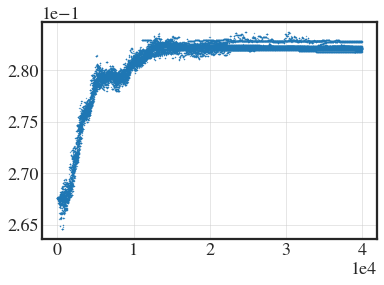

In [272]:
plt.scatter(np.arange(len(flat['vphot'])), flat['vphot'], s = 0.1)


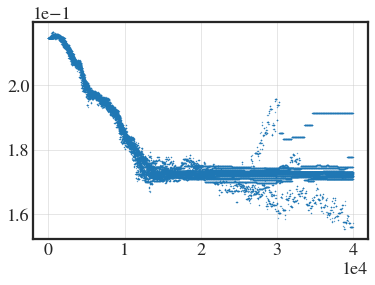

In [276]:
plt.scatter(np.arange(len(flat['vphot'])), flat['v_bb'], s = 0.1)

In [278]:
import corner

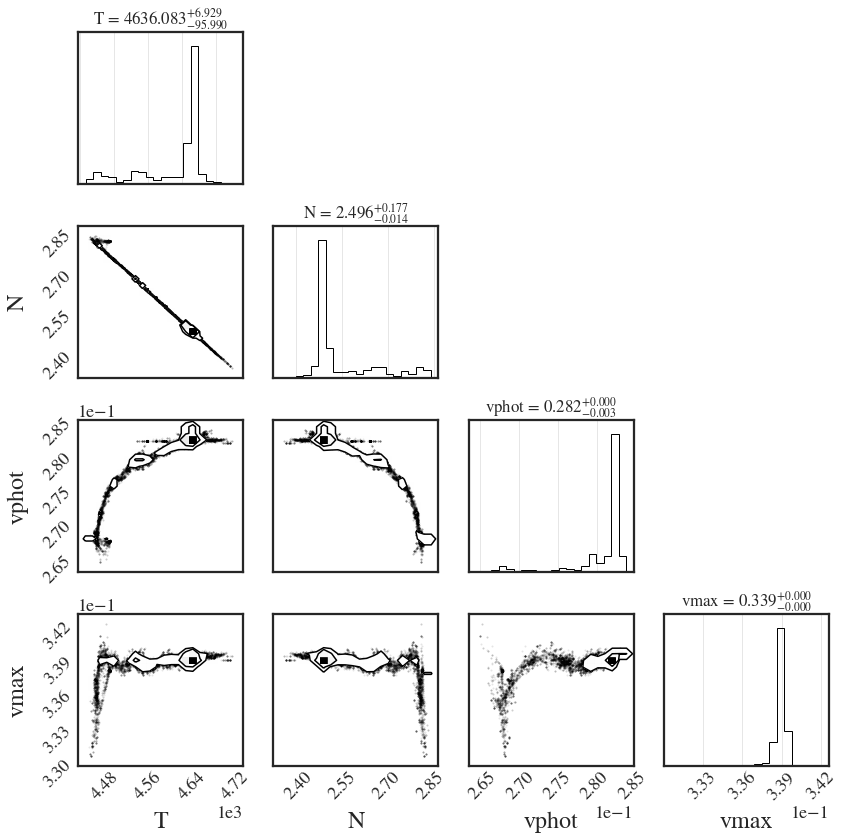

In [279]:
fig,ax = plt.subplots(figsize=(12,12),nrows=4,ncols=4)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax']]).T, 
            labels=['T', 'N', 'vphot','vmax'], show_titles=True, 
            fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

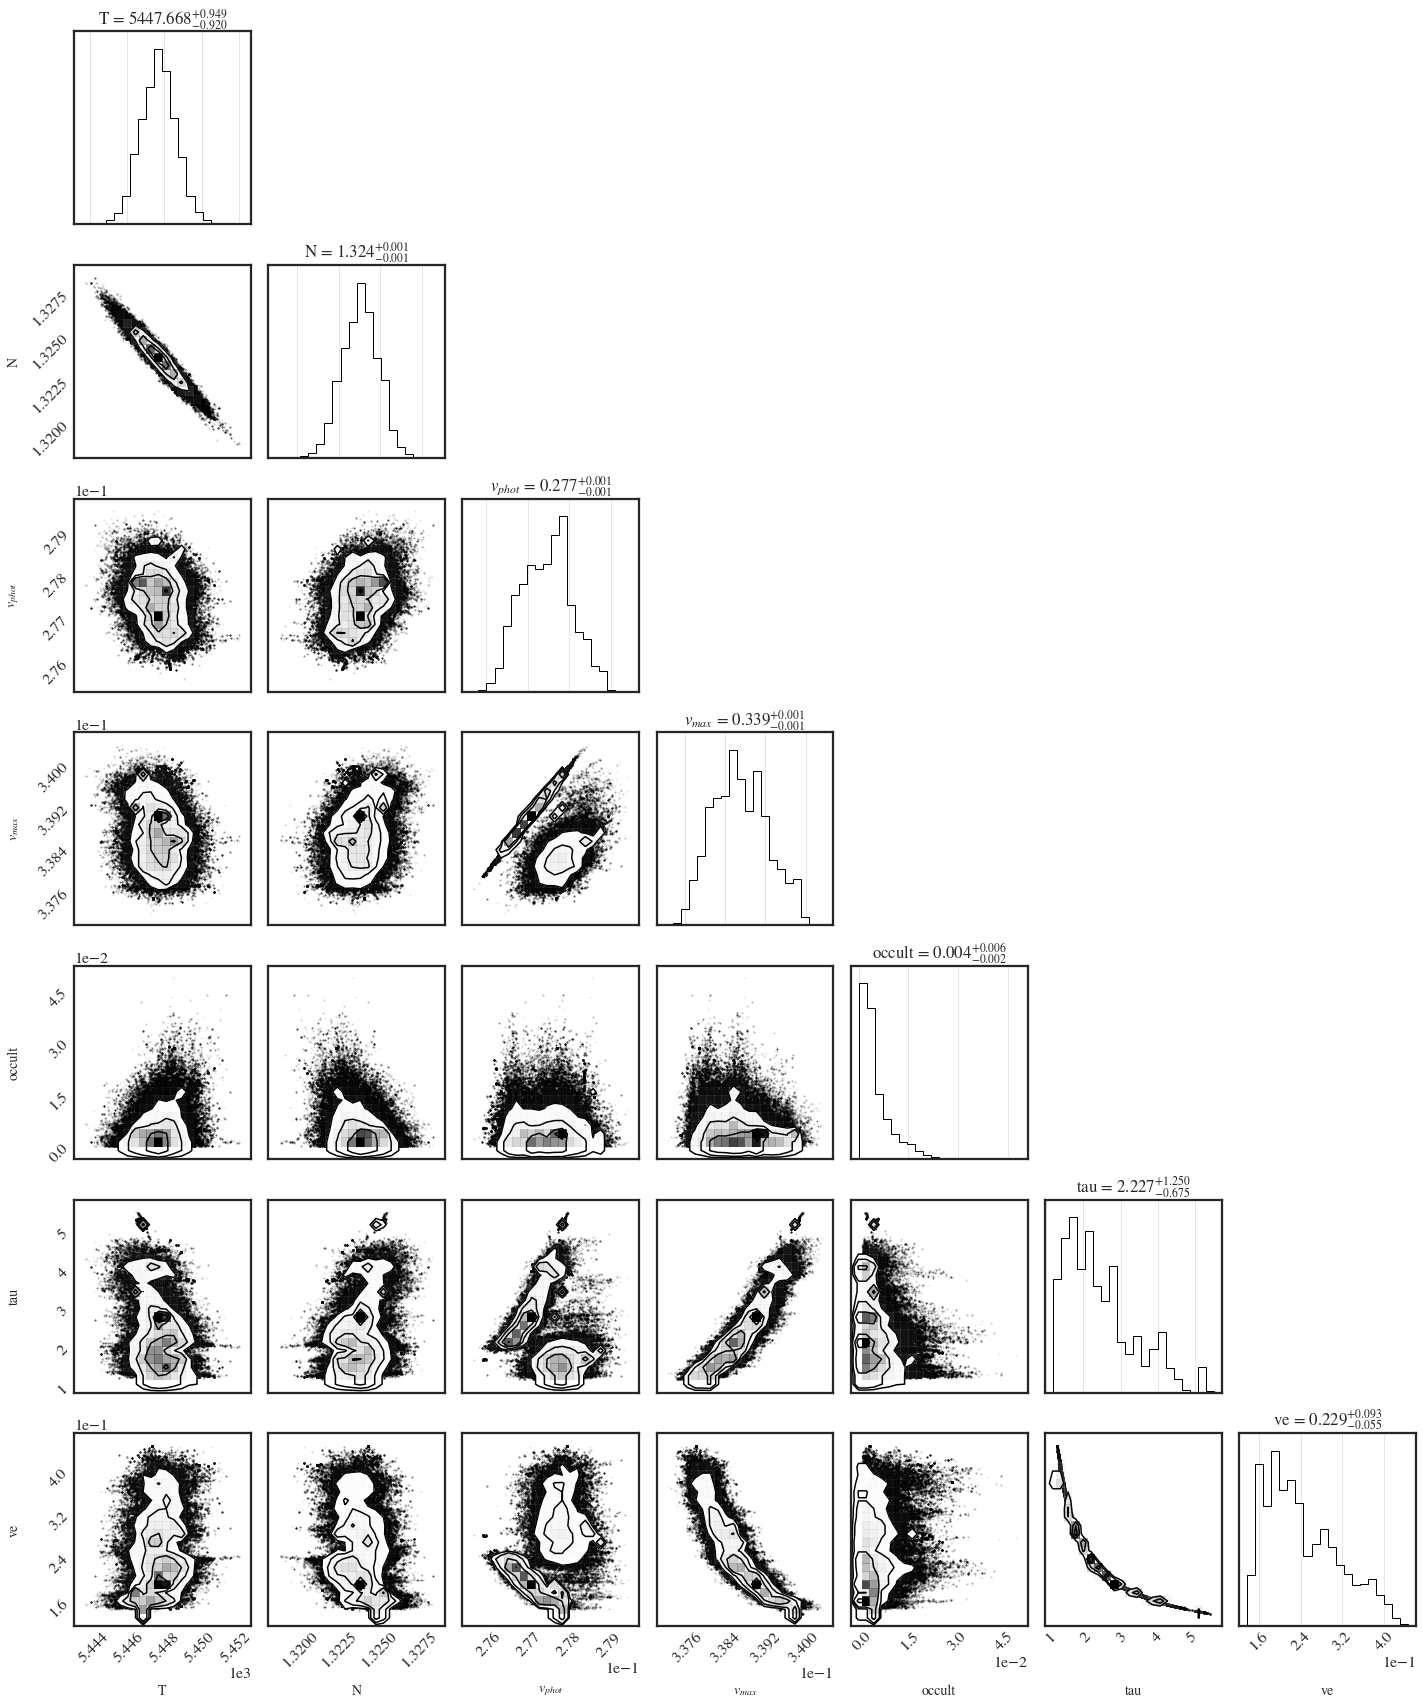

In [83]:
n_box = 7
fig,ax = plt.subplots(figsize=(20,24),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax'], flat['occult'], flat['tau'], flat['ve']]).T, 
              labels=['T', 'N', r'$v_{phot}$', r'$v_{max}$','occult','tau','ve'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

plt.savefig('Pictures/OB1_covariance_large.png', dpi=300)

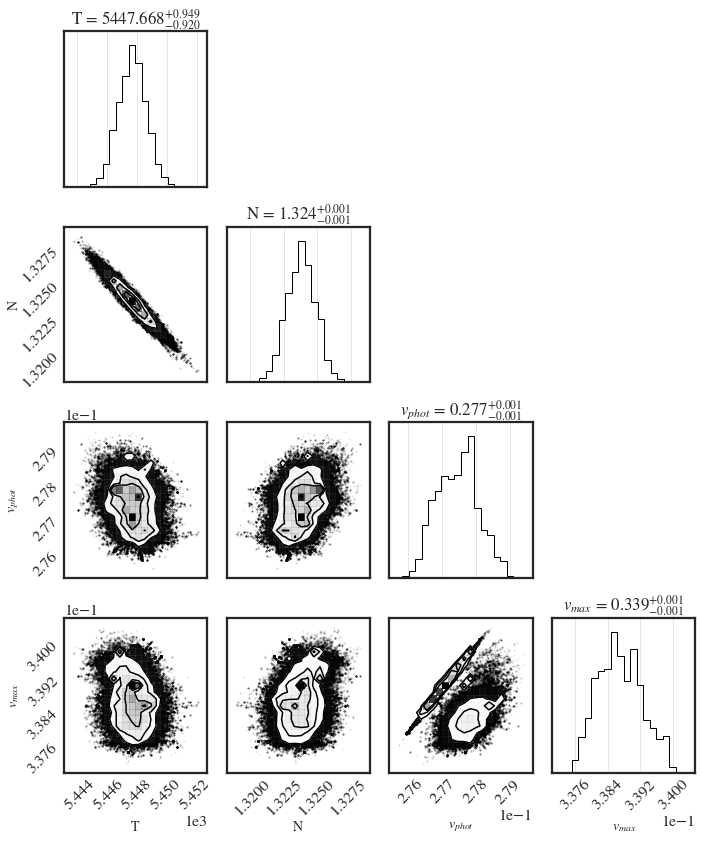

In [39]:
n_box = 4
fig,ax = plt.subplots(figsize=(10,12),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax']]).T, 
              labels=['T', 'N', r'$v_{phot}$', r'$v_{max}$'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

#plt.savefig('Pictures/OB1_covariance_small.png', dpi=300)

In [60]:
## day 1
1+(23-12)/24+(21-41)/24/60

#23:45:35
#23:34:00
#23:22:22
#23:57:12
        
dtime1 = 1 + (23-12)/24 + (np.mean([16])-41)/(24*60)
dtime1

1.440972222222222

In [61]:
## day 2
2+(23-12)/24+(28-41)/24/60

# 23:53:42
# 23:58:38
# 23:38:35
# 23:28:45

dtime2 = 2 + (23-12)/24 + (np.mean([23])-41)/(24*60)
dtime2

2.4458333333333333

In [54]:
3+(24-12)/24+(5-41)/24/60

#  23:25:24
#  23:37:01
#  23:48:40
#  00:23:28
#  00:11

dtime3 = 3 + (23-12)/24 + (np.mean([25, 37, 48, 23+60, 11+60])-41)/(24*60)
dtime3

3.466527777777778

In [58]:
30/24/60

0.020833333333333332

In [62]:
3+(24-12)/24+(5-41)/24/60

#  23:50
#  23:25
#  23:30
#  23:35

dtime4 = 4 + (23-12)/24 + (np.mean([13])-41)/(24*60)
dtime4

4.438888888888888

In [31]:
## day 4
4+(23-12)/24+(50-41)/24/60

4.464583333333333

In [40]:
30/24/60

0.020833333333333332